<a href="https://colab.research.google.com/github/heropaulexy79/Predicting-House-Prices-in-Lekki/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

# **Import Libraries and Data**

In [50]:
# Import Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [3]:
# Read in data as dataframe
df = pd.read_csv('/content/nigeria_houses_data.csv')
df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


In [4]:
# Explore data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


In [5]:
# Descriptive statistics
df.describe()

,bedrooms,bathrooms,toilets,parking_space,price
count,24326.000000,24326.000000,24326.000000,24326.000000,2.432600e+04
mean,4.338814,4.600798,5.176355,4.041725,3.013802e+08
std,1.138497,1.163161,1.226253,1.399936,1.220403e+10
min,1.000000,1.000000,1.000000,1.000000,9.000000e+04
25%,4.000000,4.000000,5.000000,4.000000,5.200000e+07
50%,4.000000,5.000000,5.000000,4.000000,8.500000e+07
75%,5.000000,5.000000,6.000000,4.000000,1.600000e+08
max,9.000000,9.000000,9.000000,9.000000,1.800000e+12


In [6]:
# Rename title column
df = df.rename(columns={'title':'property_type'})

In [7]:
# Check for unique property types
df['property_type'].unique()

array(['Detached Duplex', 'Terraced Duplexes', 'Semi Detached Duplex',
       'Detached Bungalow', 'Block of Flats', 'Semi Detached Bungalow',
       'Terraced Bungalow'], dtype=object)

In [8]:
# Convert price column back to float
df["price"] = df["price"].apply(lambda x: float(x))
# Create a custom tick formatter to display prices in decimal notation
def price_formatter(x, pos):
    return f'{x:.2f}'

# **Exploratory Data Analysis**

(array([-2.50e+11,  0.00e+00,  2.50e+11,  5.00e+11,  7.50e+11,  1.00e+12,
         1.25e+12,  1.50e+12,  1.75e+12,  2.00e+12]),
 [Text(-250000000000.0, 0, '-250000000000.00'),
  Text(0.0, 0, '0.00'),
  Text(250000000000.0, 0, '250000000000.00'),
  Text(500000000000.0, 0, '500000000000.00'),
  Text(750000000000.0, 0, '750000000000.00'),
  Text(1000000000000.0, 0, '1000000000000.00'),
  Text(1250000000000.0, 0, '1250000000000.00'),
  Text(1500000000000.0, 0, '1500000000000.00'),
  Text(1750000000000.0, 0, '1750000000000.00'),
  Text(2000000000000.0, 0, '2000000000000.00')])

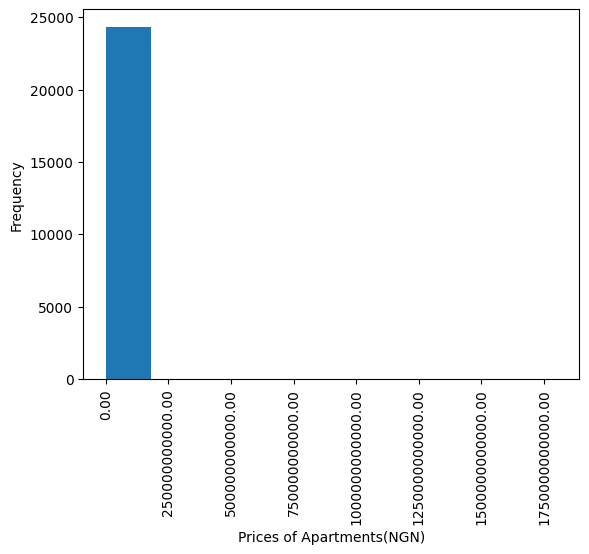

In [9]:
# Check distribution of the prices of the properties
fig, ax = plt.subplots()
ax.hist(df['price'])
ax.xaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.xlabel("Prices of Apartments(NGN)")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

Based on the visualization presented, it's evident that our dataset contains a notable presence of outliers. These outliers can significantly impact the modeling process and the reliability of the results. To ensure the development of a robust and accurate model, it is advisable to consider outlier removal as an essential data preprocessing step. This procedure involves the identification and elimination of data points that deviate significantly from the norm, which can distort the model's predictive capabilities and overall performance. By addressing these outliers, we aim to enhance the quality and trustworthiness of the model's output.

In [10]:
Q1 = df["price"].quantile(0.15)
Q3 = df["price"].quantile(0.85)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]
df.head()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0
5,5.0,5.0,6.0,1.0,Detached Duplex,Lekki,Lagos,450000000.0


(array([-1.e+08,  0.e+00,  1.e+08,  2.e+08,  3.e+08,  4.e+08,  5.e+08,
         6.e+08,  7.e+08]),
 [Text(-100000000.0, 0, '-100000000.00'),
  Text(0.0, 0, '0.00'),
  Text(100000000.0, 0, '100000000.00'),
  Text(200000000.0, 0, '200000000.00'),
  Text(300000000.0, 0, '300000000.00'),
  Text(400000000.0, 0, '400000000.00'),
  Text(500000000.0, 0, '500000000.00'),
  Text(600000000.0, 0, '600000000.00'),
  Text(700000000.0, 0, '700000000.00')])

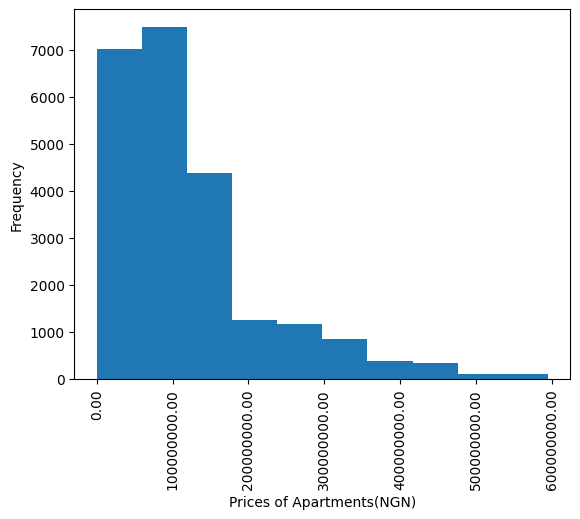

In [11]:
# Check distribution of the prices of the properties
fig, ax = plt.subplots()
ax.hist(df['price'])
ax.xaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.xlabel("Prices of Apartments(NGN)")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

(array([0.e+00, 1.e+08, 2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08]),
 [Text(0.0, 0, '0.00'),
  Text(100000000.0, 0, '100000000.00'),
  Text(200000000.0, 0, '200000000.00'),
  Text(300000000.0, 0, '300000000.00'),
  Text(400000000.0, 0, '400000000.00'),
  Text(500000000.0, 0, '500000000.00'),
  Text(600000000.0, 0, '600000000.00'),
  Text(700000000.0, 0, '700000000.00')])

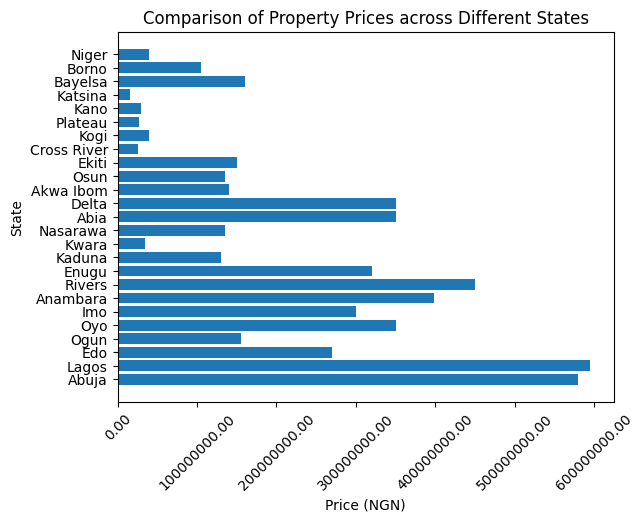

In [12]:
# Visualize Comparison of Property Prices across Different States
fig, ax = plt.subplots()
ax.barh(df['state'], df['price'])
# Apply the custom price formatter to the y-axis
ax.xaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.xlabel("Price (NGN)")
plt.ylabel("State")
plt.title("Comparison of Property Prices across Different States")
plt.xticks(rotation=45)

(array([0.e+00, 1.e+08, 2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08]),
 [Text(0.0, 0, '0.00'),
  Text(100000000.0, 0, '100000000.00'),
  Text(200000000.0, 0, '200000000.00'),
  Text(300000000.0, 0, '300000000.00'),
  Text(400000000.0, 0, '400000000.00'),
  Text(500000000.0, 0, '500000000.00'),
  Text(600000000.0, 0, '600000000.00'),
  Text(700000000.0, 0, '700000000.00')])

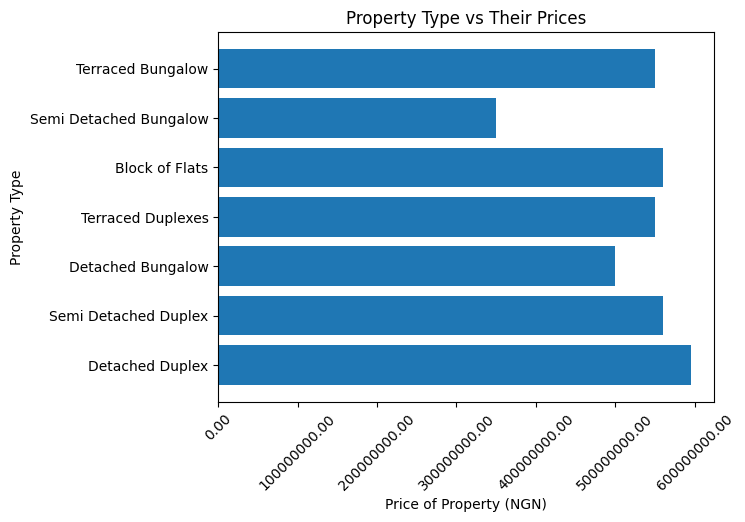

In [13]:
# Visualize Property Type vs Their Prices
fig, ax = plt.subplots()
ax.barh(df['property_type'], df['price'])
# Apply the custom price formatter to the y-axis
ax.xaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.xlabel("Price of Property (NGN)")
plt.ylabel("Property Type")
plt.title("Property Type vs Their Prices")
plt.xticks(rotation=45)

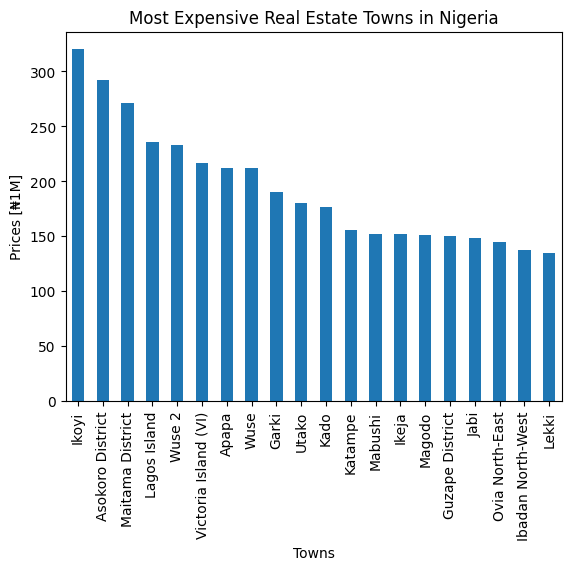

In [14]:
# Visualize the Most Expensive Real Estate Towns in Nigeria
(
    (df.groupby("town")['price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .head(20)
    .plot(kind="bar",
         xlabel = 'Towns',
         ylabel = "Prices [₦1M]",
         title = "Most Expensive Real Estate Towns in Nigeria")
);

In [15]:
# Checking the values in different states
values = df['state'].value_counts()
mask = values > 100
selected_states = values.index[mask]
df = df[df['state'].isin(selected_states)]

In [16]:
df['state'].value_counts()

Lagos       17524
Abuja        3221
Ogun          637
Oyo           477
Rivers        434
Imo           246
Anambara      143
Enugu         128
Name: state, dtype: int64

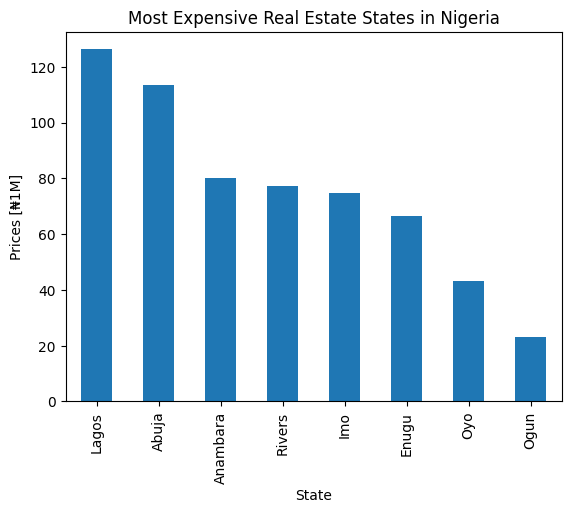

In [17]:
# Visualize the Most Expensive Real Estate States in Nigeria
(
    (df.groupby("state")['price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .head(10)
    .plot(kind="bar",
         xlabel = 'State',
         ylabel = "Prices [₦1M]",
         title = "Most Expensive Real Estate States in Nigeria")
);

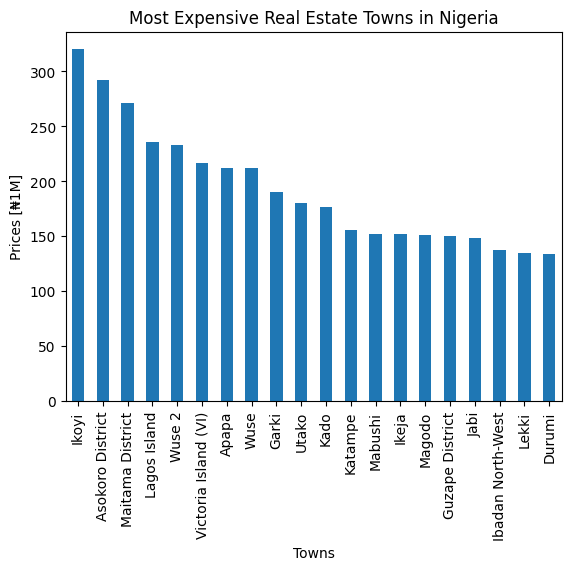

In [18]:
# Visualize the Most Expensive Real Estate Towns in Nigeria
(
    (df.groupby("town")['price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .head(20)
    .plot(kind="bar",
         xlabel = 'Towns',
         ylabel = "Prices [₦1M]",
         title = "Most Expensive Real Estate Towns in Nigeria")
);

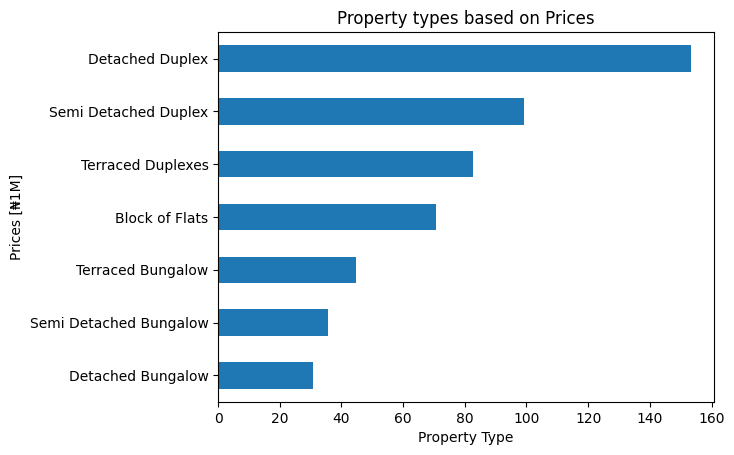

In [19]:
# Visualize the Property types based on Prices in Nigeria
(
    (df.groupby("property_type")['price']
    .mean()/1e6)
    .sort_values()
    .head(20)
    .plot(kind="barh",
         xlabel = 'Property Type',
         ylabel = "Prices [₦1M]",
         title = "Property types based on Prices")
);

In [20]:
lagos_df = df[df['state'] == "Lagos"]
lagos_df.head()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0
5,5.0,5.0,6.0,1.0,Detached Duplex,Lekki,Lagos,450000000.0
6,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0


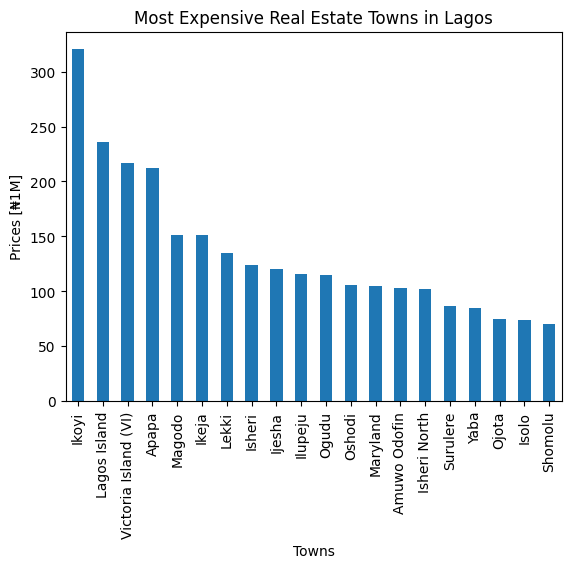

In [21]:
(
    (lagos_df.groupby("town")['price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .head(20)
    .plot(kind="bar",
         xlabel = 'Towns',
         ylabel = "Prices [₦1M]",
         title = "Most Expensive Real Estate Towns in Lagos")
);

In [22]:
# Remove suspected outliers
Q1 = lagos_df["price"].quantile(0.15)
Q3 = lagos_df["price"].quantile(0.85)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
lagos_df = lagos_df[(lagos_df["price"] >= lower_bound) & (lagos_df["price"] <= upper_bound)]
lagos_df.reset_index(drop=True).head()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price
0,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
1,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
2,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0
3,5.0,5.0,6.0,1.0,Detached Duplex,Lekki,Lagos,450000000.0
4,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0


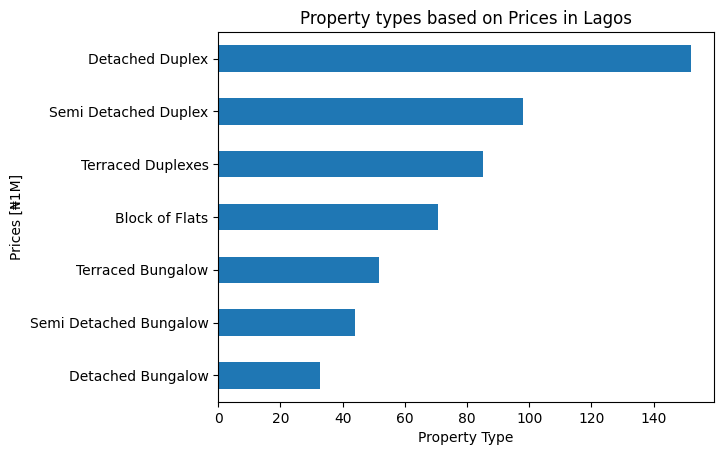

In [23]:
# Visualize the Property types based on Prices in Lagos
(
    (lagos_df.groupby("property_type")['price']
    .mean()/1e6)
    .sort_values()
    .head(10)
    .plot(kind="barh",
         xlabel = 'Property Type',
         ylabel = "Prices [₦1M]",
         title = "Property types based on Prices in Lagos")
);

In [24]:
values = lagos_df['town'].value_counts()
mask = values > 100
selected_towns = values.index[mask]
lagos_df = lagos_df[lagos_df['town'].isin(selected_towns)]
lagos_df = lagos_df.reset_index(drop=True)
lagos_df.head()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price
0,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
1,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
2,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0
3,5.0,5.0,6.0,1.0,Detached Duplex,Lekki,Lagos,450000000.0
4,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0


In [25]:
selected_towns

Index(['Lekki', 'Ajah', 'Ikeja', 'Ikoyi', 'Ibeju Lekki',
       'Victoria Island (VI)', 'Magodo', 'Ikorodu', 'Isheri North', 'Isolo',
       'Alimosho', 'Agege', 'Surulere'],
      dtype='object')

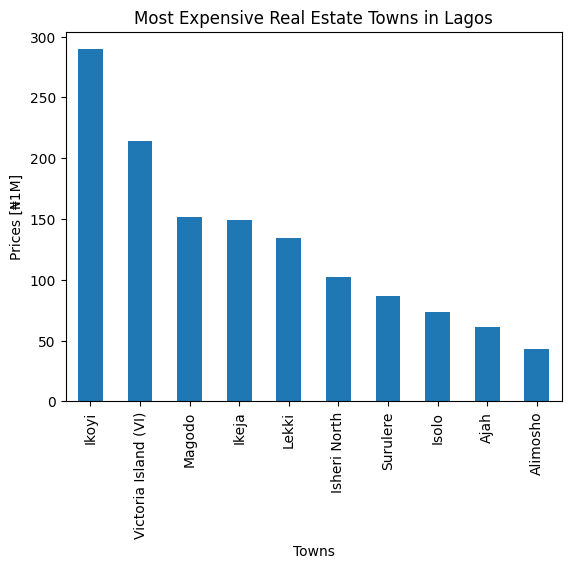

In [26]:
(
    (lagos_df.groupby("town")['price']
    .mean()/1e6)
    .sort_values(ascending=False)
    .head(10)
    .plot(kind="bar",
         xlabel = 'Towns',
         ylabel = "Prices [₦1M]",
         title = "Most Expensive Real Estate Towns in Lagos")
);

<ipython-input-27-f856e443e040>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = lagos_df.corr()


<Axes: >

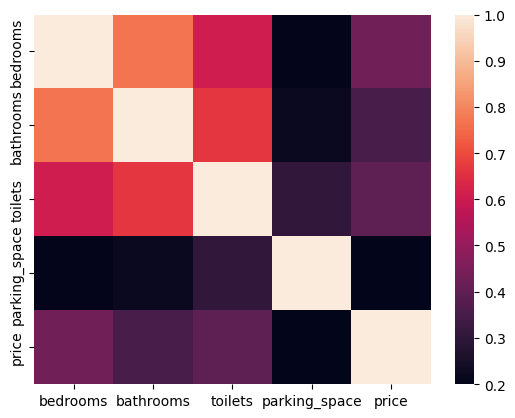

In [27]:
# Check for Multi-Colinearity
correlation = lagos_df.corr()
sns.heatmap(correlation)

In [28]:
correlation = lagos_df.corr()
correlation

<ipython-input-28-c20e466d801b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = lagos_df.corr()


,bedrooms,bathrooms,toilets,parking_space,price
bedrooms,1.000000,0.767793,0.608971,0.205374,0.430523
bathrooms,0.767793,1.000000,0.664335,0.219880,0.353792
toilets,0.608971,0.664335,1.000000,0.306101,0.394077
parking_space,0.205374,0.219880,0.306101,1.000000,0.199840
price,0.430523,0.353792,0.394077,0.199840,1.000000


# **Houses in Lekki Prediction Model**

In [29]:
df_lekki = lagos_df[lagos_df['town'] == "Lekki"]
df_lekki = df_lekki.reset_index(drop=True)
df_lekki.head()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price
0,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
1,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0
2,5.0,5.0,6.0,1.0,Detached Duplex,Lekki,Lagos,450000000.0
3,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0
4,1.0,1.0,1.0,1.0,Detached Duplex,Lekki,Lagos,200000000.0


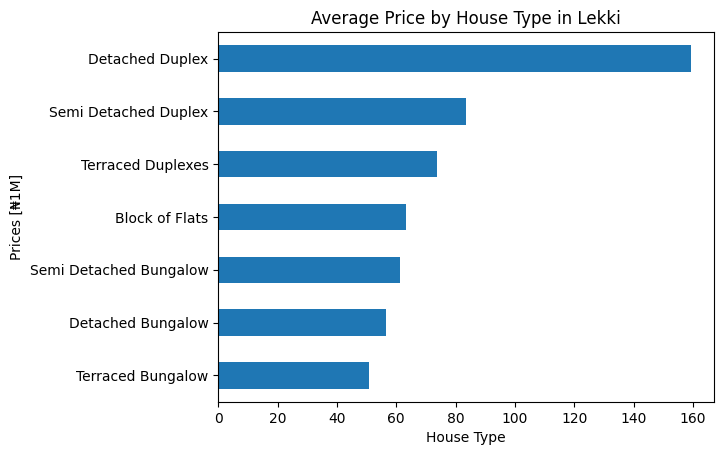

In [30]:
(df_lekki.groupby("property_type")["price"].mean()/1e6).sort_values().plot(
          kind="barh",
           xlabel = "House Type",
           ylabel = "Prices [₦1M]",
           title = "Average Price by House Type in Lekki"
      );

In [31]:
# Remove suspected outliers
Q1 = df_lekki["price"].quantile(0.05)
Q3 = df_lekki["price"].quantile(0.95)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_lekki = df_lekki[(df_lekki["price"] >= lower_bound) & (df_lekki["price"] <= upper_bound)]
df_lekki.reset_index(drop=True).head()

,bedrooms,bathrooms,toilets,parking_space,property_type,town,state,price
0,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
1,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0
2,5.0,5.0,6.0,1.0,Detached Duplex,Lekki,Lagos,450000000.0
3,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0
4,1.0,1.0,1.0,1.0,Detached Duplex,Lekki,Lagos,200000000.0


<ipython-input-32-d80ae1261ad1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_lekki.corr()


<Axes: >

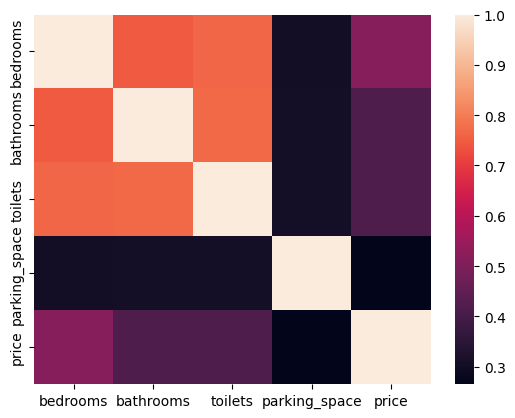

In [32]:
corr = df_lekki.corr()
sns.heatmap(corr)

# **Splitting the Data**

In [33]:
X = df_lekki.drop(columns=["parking_space","bathrooms","state","price","town"])
y = df_lekki["price"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Calculate baseline model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
y_baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("The mean is", y_mean)
print("The baseline Mean Absolute Error is", y_baseline_mae)

The mean is 134730440.91034403
The baseline Mean Absolute Error is 68981908.58648624


#**Training the Model**

In [36]:
# Train model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['property_type'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

# **Evaluating the Model**

In [37]:
y_pred_training = model.predict(X_train)
y_train_mae = mean_absolute_error(y_train, y_pred_training)
print("The Mean Absolute Error of the Training Data is", y_train_mae)

The Mean Absolute Error of the Training Data is 56856339.16723276


In [38]:
y_pred_test = model.predict(X_test)
y_test_mae = mean_absolute_error(y_test, y_pred_test)
print("The Mean Absolute Error of the Test Data is", y_test_mae)

The Mean Absolute Error of the Test Data is 55711638.18870988


In [39]:
test_result_data = pd.DataFrame({'test_price': y_test, 'prediction_price': y_pred_test})
test_result_data = test_result_data.reset_index(drop=True)
test_result_data.head()

,test_price,prediction_price
0,90000000.0,1.643044e+08
1,270000000.0,7.455425e+07
2,200000000.0,1.704298e+08
3,83000000.0,1.074988e+08
4,89500000.0,1.765551e+08


<Axes: >

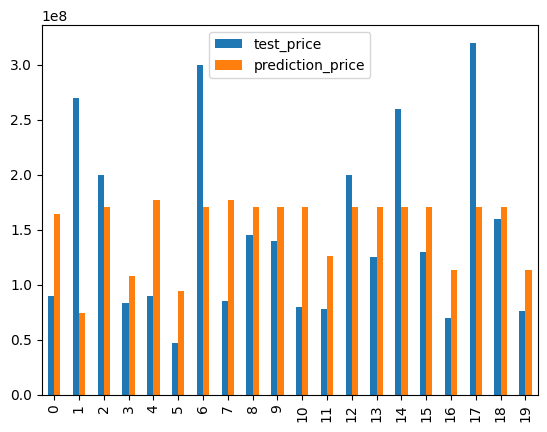

In [40]:
test_result_data.head(20).plot(kind="bar")

In [41]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 77704707.27867293


# **Communicating the Result**

In [45]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("intercept:", intercept)
print(coefficients[:5])

intercept: -134031958.2685518
[ 50680311.11774644   6125320.21954607  14308245.22632078
 -15398723.69906786 -18636317.88412237]


In [46]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print(feature_names)

['bedrooms' 'toilets' 'property_type_Detached Duplex'
 'property_type_Terraced Duplexes' 'property_type_Semi Detached Duplex'
 'property_type_Detached Bungalow' 'property_type_Block of Flats'
 'property_type_Terraced Bungalow' 'property_type_Semi Detached Bungalow']


/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


In [47]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

bedrooms                              5.068031e+07
toilets                               6.125320e+06
property_type_Detached Duplex         1.430825e+07
property_type_Terraced Duplexes      -1.539872e+07
property_type_Semi Detached Duplex   -1.863632e+07
dtype: float64

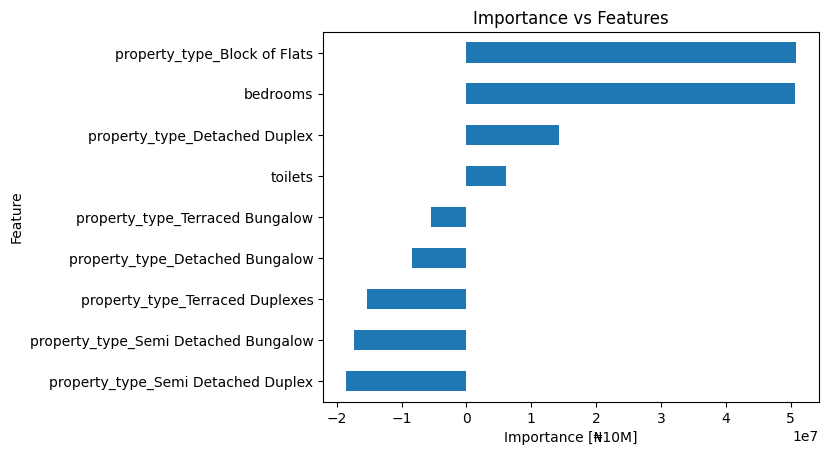

In [49]:
feat_imp.sort_values().plot(kind="barh")
plt.xlabel("Importance [₦10M]")
plt.ylabel("Feature")
plt.title("Importance vs Features");

The barplot provided clearly illustrates the influence of the number of bedrooms on property prices, indicating that this particular feature holds the most substantial impact on pricing. Furthermore, it is worth noting that the housing type, specifically, being a Semi Detached Duplex, is associated with a significant reduction in property prices, reflecting a decrease of approximately 20 million naira. These observations underscore the importance of these factors in understanding the pricing dynamics within the real estate market.

# **Making Predictions**

In [42]:
def make_prediction(bedrooms, toilets, property_type):
    data = {"bedrooms":bedrooms,
            "toilets":toilets,
            "property_type":property_type
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ₦{prediction}"

In [43]:
make_prediction(4, 3, 'Terraced Bungalow')

'Predicted apartment price: ₦81626976.31'

In [52]:
interact(
    make_prediction,
    bedrooms=IntSlider(
        min=X_train["bedrooms"].min(),
        max=X_train["bedrooms"].max(),
        value=X_train["bedrooms"].mean(),
    ),
    toilets=IntSlider(
        min=X_train["toilets"].min(),
        max=X_train["toilets"].max(),
        step=1,
        value=X_train["toilets"].mean(),
    ),
    property_type=Dropdown(options=sorted(X_train["property_type"].unique())),
);

interactive(children=(IntSlider(value=4, description='bedrooms', max=9, min=1), IntSlider(value=5, description…